In [ ]:
# Install required packages
!pip install -q tensorflow numpy pandas  keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 2.9 MB/s eta 0:00:00


In [ ]:
# Import libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import json
from datetime import datetime
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, RepeatVector, TimeDistributed, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"✅ TensorFlow version: {tf.__version__}")
print(f"✅ GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")
print(f"✅ All libraries imported successfully")

✅ TensorFlow version: 2.19.0
✅ GPU available: False
✅ All libraries imported successfully


In [ ]:
# Upload CAN data file
from google.colab import files

print("📂 Please upload your CAN data file (safe_ev_can_data.xlsx):")
uploaded = files.upload()

if uploaded:
    print(f"✅ File uploaded successfully: {list(uploaded.keys())[0]}")
else:
    print("❌ No file uploaded")

📂 Please upload your CAN data file (safe_ev_can_data.xlsx):


Saving safe_ev_can_data.xlsx to safe_ev_can_data (1).xlsx
✅ File uploaded successfully: safe_ev_can_data (1).xlsx


In [ ]:
# Mount Google Drive for weight storage
from google.colab import drive

drive.mount('/content/drive')

# Configuration
DRIVE_BASE = '/content/drive/MyDrive/federated_learning'
CLIENT_ID = 2  # Change this for different devices
ROUND_NUM = 1  # Federated learning round number

os.makedirs(DRIVE_BASE, exist_ok=True)

print(f"✅ Google Drive mounted successfully")
print(f"📁 Storage path: {DRIVE_BASE}")
print(f"🔢 Client ID: {CLIENT_ID}")
print(f"🔄 Round: {ROUND_NUM}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted successfully
📁 Storage path: /content/drive/MyDrive/federated_learning
🔢 Client ID: 2
🔄 Round: 1


In [ ]:
# Data Preparation Functions

def decode_payload(row):
    """Decode CAN payload with error handling"""
    try:
        payload = str(row['Payload']).replace(' ', '')
        if pd.isna(payload) or payload == 'nan':
            return pd.Series({})

        if len(payload) % 2 != 0:
            payload = '0' + payload

        bytes_data = [int(payload[i:i+2], 16) for i in range(0, len(payload), 2)]
        can_id = str(row['ID'])
        decoded = {}

        if can_id == '18FF10E5' and len(bytes_data) >= 1:
            decoded['Vehicle_Speed_kmh'] = bytes_data[0]
        elif can_id == '18FF50E5' and len(bytes_data) >= 6:
            decoded['BMS_Level'] = bytes_data[0]
            decoded['BMS_Voltage_V'] = (bytes_data[2] << 8 | bytes_data[3]) * 0.1
            decoded['BMS_Current_A'] = (bytes_data[4] << 8 | bytes_data[5])
        elif can_id == '18FF21E5' and len(bytes_data) >= 1:
            decoded['Motor_Power_kW'] = bytes_data[0]
        elif can_id == '18FF31E5' and len(bytes_data) >= 1:
            decoded['Temperature_C'] = bytes_data[0]
        elif can_id == '18FF40E5' and len(bytes_data) >= 8:
            decoded['Charger_Status'] = bytes_data[0]
            decoded['alpha'] = (bytes_data[1] << 8 | bytes_data[2]) * 0.01
            decoded['betha'] = (bytes_data[3] << 8 | bytes_data[4]) * 0.01
            decoded['gamma'] = (bytes_data[5] << 8 | bytes_data[6])
            decoded['khi'] = bytes_data[7]

        return pd.Series(decoded)
    except Exception as e:
        return pd.Series({})

def compute_acceleration(df):
    """Compute acceleration from speed data"""
    df = df.copy()
    df['speed_m_s'] = df['Vehicle_Speed_kmh'].fillna(0) / 3.6
    df['delta_time'] = df['Timestamp'].diff().dt.total_seconds()
    df['delta_speed'] = df['speed_m_s'].diff()
    df['acceleration'] = np.where(
        (df['delta_time'] > 0) & (df['delta_time'].notna()),
        df['delta_speed'] / df['delta_time'],
        0
    )
    return df

def prepare_can_data():
    """Prepare CAN data by decoding and processing"""
    print("\n" + "="*60)
    print("📊 PREPARING CAN DATA")
    print("="*60)

    try:
        df = pd.read_excel('safe_ev_can_data (1).xlsx')
        df.to_csv('data.csv', index=False, encoding='utf-8')
        print("✅ Excel file loaded and converted to CSV")
    except FileNotFoundError:
        try:
            df = pd.read_csv('data.csv', parse_dates=['Timestamp'])
            print("✅ Loaded from existing CSV")
        except FileNotFoundError:
            print("❌ Error: No data file found")
            return None, None, None

    # Decode payloads
    decoded_df = df.apply(decode_payload, axis=1)
    result_df = pd.concat([df, decoded_df], axis=1)
    result_df.to_csv('decoded_can_data.csv', index=False)
    print("✅ Payloads decoded")

    # Read and process
    data = pd.read_csv("decoded_can_data.csv", parse_dates=['Timestamp'])
    one_hot_encoded = pd.get_dummies(data['ID'], prefix='ID').astype(int)
    data = pd.concat([data, one_hot_encoded], axis=1)
    data = compute_acceleration(data)
    data['acceleration'].fillna(0, inplace=True)

    # Define features
    features = [
        'BMS_Current_A', 'BMS_Level', 'BMS_Voltage_V', 'Charger_Status',
        'Motor_Power_kW', 'Temperature_C', 'Vehicle_Speed_kmh',
        'ID_18FF10E5', 'ID_18FF21E5', 'ID_18FF31E5', 'ID_18FF40E5', 'ID_18FF50E5',
        'acceleration'
    ]

    existing_features = [f for f in features if f in data.columns]

    if existing_features:
        df_features = data[existing_features].copy()
        for col in existing_features:
            df_features[col] = pd.to_numeric(df_features[col], errors='coerce')
        df_features = df_features.ffill().bfill().fillna(0)

        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(df_features)
        data_scaled = pd.DataFrame(data_scaled, columns=df_features.columns)
        data_scaled = data_scaled.replace([np.inf, -np.inf], 0)

        print(f"✅ Features: {len(existing_features)}, Samples: {data_scaled.shape[0]}")
        print("="*60)

        return data_scaled.values, scaler, existing_features
    else:
        return None, None, None

def create_sequences(data, timesteps=20):
    """Create sequences from time series data for LSTM"""
    if data is None:
        return None

    n_samples = len(data) - timesteps + 1
    n_features = data.shape[1]
    sequences = np.zeros((n_samples, timesteps, n_features))

    for i in range(n_samples):
        sequences[i] = data[i:i+timesteps]

    print(f"✅ Created {n_samples} sequences of shape ({timesteps}, {n_features})")
    return sequences

print("✅ Data preparation functions defined")

✅ Data preparation functions defined


In [ ]:
# Model Building Functions

def build_lstm_autoencoder(seq_length, n_features, latent_dim=48, activation='tanh',
                          dropout_rate=0, learning_rate=0.000602358853272268):
    """Build LSTM autoencoder with 3 hidden layers"""
    layer1_units = 64
    layer2_units = 58
    layer3_units = latent_dim

    inputs = Input(shape=(seq_length, n_features), name='can_input')

    # ENCODER
    encoder = LSTM(layer1_units, activation=activation, return_sequences=True, name='encoder_lstm_1')(inputs)
    if dropout_rate > 0:
        encoder = Dropout(dropout_rate, name='encoder_dropout_1')(encoder)

    encoder = LSTM(layer2_units, activation=activation, return_sequences=True, name='encoder_lstm_2')(encoder)
    if dropout_rate > 0:
        encoder = Dropout(dropout_rate, name='encoder_dropout_2')(encoder)

    encoded = LSTM(layer3_units, activation=activation, return_sequences=False, name='encoder_lstm_3')(encoder)

    # DECODER
    decoder = RepeatVector(seq_length, name='repeat_vector')(encoded)
    decoder = LSTM(layer3_units, activation=activation, return_sequences=True, name='decoder_lstm_1')(decoder)
    if dropout_rate > 0:
        decoder = Dropout(dropout_rate, name='decoder_dropout_1')(decoder)

    decoder = LSTM(layer2_units, activation=activation, return_sequences=True, name='decoder_lstm_2')(decoder)
    if dropout_rate > 0:
        decoder = Dropout(dropout_rate, name='decoder_dropout_2')(decoder)

    decoder = LSTM(layer1_units, activation=activation, return_sequences=True, name='decoder_lstm_3')(decoder)
    outputs = TimeDistributed(Dense(n_features), name='decoder_output')(decoder)

    model = Model(inputs=inputs, outputs=outputs, name='lstm_autoencoder_3layers')
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])

    return model

def evaluate_autoencoder_performance(model, test_data):
    """Calculate comprehensive metrics for autoencoder evaluation"""
    reconstructions = model.predict(test_data, verbose=0)

    mse = np.mean(np.square(test_data - reconstructions))
    mae = np.mean(np.abs(test_data - reconstructions))
    rmse = np.sqrt(mse)

    ss_total = np.sum(np.square(test_data - np.mean(test_data)))
    ss_residual = np.sum(np.square(test_data - reconstructions))
    r2 = 1 - (ss_residual / ss_total)

    feature_mse = np.mean(np.square(test_data - reconstructions), axis=(0, 1))

    print("\n📈 Evaluation Metrics:")
    print(f"  MSE:  {mse:.6f}")
    print(f"  MAE:  {mae:.6f}")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  R²:   {r2:.6f}")

    plt.figure(figsize=(12, 5))
    sns.barplot(x=list(range(len(feature_mse))), y=feature_mse)
    plt.title('Mean Squared Error by Feature', fontsize=14, fontweight='bold')
    plt.xlabel('Feature Index')
    plt.ylabel('MSE')
    plt.tight_layout()
    plt.savefig('feature_mse.png', dpi=150)
    plt.show()

    return {"mse": mse, "mae": mae, "rmse": rmse, "r2": r2, "feature_mse": feature_mse}

print("✅ Model building functions defined")

✅ Model building functions defined


In [ ]:
# Training Function

def train_lstm_model(X_train, X_test, n_features, epochs=50, batch_size=32):
    """Train the LSTM autoencoder model"""
    print("\n" + "="*60)
    print("🚀 TRAINING LSTM AUTOENCODER")
    print("="*60)

    seq_length = X_train.shape[1]
    model = build_lstm_autoencoder(seq_length, n_features)
    model.summary()

    model_size_bytes = sum(w.nbytes for layer in model.layers for w in layer.get_weights())
    model_size_mb = model_size_bytes / (1024 * 1024)
    print(f"\n📊 Model size: {model_size_mb:.2f} MB")
    print(f"📊 Total parameters: {model.count_params():,}")

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
    ]

    history = model.fit(
        X_train, X_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, X_test),
        callbacks=callbacks,
        verbose=1
    )

    test_loss, test_mae = model.evaluate(X_test, X_test, verbose=0)
    print(f"\n✅ Final Test Loss: {test_loss:.4f}")
    print(f"✅ Final Test MAE:  {test_mae:.4f}")

    # Plot training history
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    ax1.plot(history.history['loss'], label='Train', linewidth=2)
    ax1.plot(history.history['val_loss'], label='Validation', linewidth=2)
    ax1.set_title('Model Loss', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss (MSE)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.plot(history.history['mae'], label='Train', linewidth=2)
    ax2.plot(history.history['val_mae'], label='Validation', linewidth=2)
    ax2.set_title('Mean Absolute Error', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('MAE')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('training_history.png', dpi=150)
    plt.show()

    metrics = evaluate_autoencoder_performance(model, X_test)
    print("="*60)

    return model, history, model_size_mb, metrics

print("✅ Training function defined")

✅ Training function defined


In [ ]:
# TFLite Conversion

def convert_lstm_to_tflite(model, sample_data, model_name="lstm_autoencoder"):
    """Convert LSTM autoencoder to TFLite with quantization"""
    print("\n" + "="*60)
    print("📱 CONVERTING TO TFLITE FOR EDGE DEPLOYMENT")
    print("="*60)

    try:
        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        converter.target_spec.supported_ops = [
            tf.lite.OpsSet.TFLITE_BUILTINS,
            tf.lite.OpsSet.SELECT_TF_OPS
        ]

        tflite_model = converter.convert()
        filename = f"{model_name}.tflite"
        with open(filename, 'wb') as f:
            f.write(tflite_model)

        size_kb = len(tflite_model) / 1024
        print(f"✅ TFLite model saved: {filename} ({size_kb:.2f} KB)")

        try:
            converter = tf.lite.TFLiteConverter.from_keras_model(model)
            converter.optimizations = [tf.lite.Optimize.DEFAULT]

            def representative_dataset_gen():
                for i in range(min(100, len(sample_data))):
                    yield [sample_data[i:i+1].astype(np.float32)]

            converter.representative_dataset = representative_dataset_gen
            converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
            converter.inference_input_type = tf.int8
            converter.inference_output_type = tf.int8

            quantized_model = converter.convert()
            quantized_filename = f"{model_name}_quantized.tflite"
            with open(quantized_filename, 'wb') as f:
                f.write(quantized_model)

            quantized_size_kb = len(quantized_model) / 1024
            print(f"✅ Quantized TFLite: {quantized_filename} ({quantized_size_kb:.2f} KB)")

            final_size = min(size_kb, quantized_size_kb)
            final_model = filename if size_kb <= quantized_size_kb else quantized_filename

        except Exception as e:
            print(f"⚠️ Quantization failed, using standard TFLite")
            final_size = size_kb
            final_model = filename

        print(f"✅ Optimized model: {final_model} ({final_size:.2f} KB)")
        print("="*60)
        return final_model, final_size

    except Exception as e:
        print(f"❌ TFLite conversion failed: {e}")
        return None, 0

print("✅ TFLite conversion function defined")

✅ TFLite conversion function defined


In [ ]:
# Weight Extraction and Google Drive Storage

def extract_and_save_weights_to_drive(model, client_id, round_num=1, base_path=DRIVE_BASE):
    """Extract model weights and save to Google Drive"""
    print("\n" + "="*60)
    print(f"💾 EXTRACTING AND SAVING WEIGHTS - CLIENT {client_id}")
    print("="*60)

    round_dir = f"{base_path}/round_{round_num}"
    client_dir = f"{base_path}/client_{client_id}"
    os.makedirs(round_dir, exist_ok=True)
    os.makedirs(client_dir, exist_ok=True)

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Save compressed weights for federated learning
    weights = model.get_weights()
    weights_file = f"{round_dir}/client_{client_id}_weights.npz"
    np.savez_compressed(weights_file, *weights)
    weights_size = os.path.getsize(weights_file) / 1024
    print(f"✅ Weights saved: {weights_file}")
    print(f"   Size: {weights_size:.2f} KB, Arrays: {len(weights)}")

    # Save detailed weights with timestamp
    detailed_weights_file = f"{client_dir}/weights_{timestamp}.npz"
    np.savez_compressed(detailed_weights_file, *weights)
    print(f"✅ Archive saved: {detailed_weights_file}")

    # Extract metadata
    metadata = {
        'client_id': client_id,
        'round': round_num,
        'timestamp': timestamp,
        'model_name': model.name,
        'total_layers': len(model.layers),
        'total_parameters': int(model.count_params()),
        'num_weight_arrays': len(weights),
        'layers': []
    }

    weight_idx = 0
    for layer in model.layers:
        layer_weights = layer.get_weights()
        if layer_weights:
            layer_info = {
                'name': layer.name,
                'type': layer.__class__.__name__,
                'num_weights': len(layer_weights),
                'shapes': [list(w.shape) for w in layer_weights],
                'weight_indices': list(range(weight_idx, weight_idx + len(layer_weights))),
                'total_params': sum(w.size for w in layer_weights)
            }
            metadata['layers'].append(layer_info)
            weight_idx += len(layer_weights)

    metadata_file = f"{client_dir}/metadata_{timestamp}.json"
    with open(metadata_file, 'w') as f:
        json.dump(metadata, f, indent=2)
    print(f"✅ Metadata saved: {metadata_file}")

    # Save individual layer weights
    layers_dir = f"{client_dir}/layers_{timestamp}"
    os.makedirs(layers_dir, exist_ok=True)

    weight_counter = 0
    for layer in model.layers:
        layer_weights = layer.get_weights()
        if layer_weights:
            for w_idx, weight_array in enumerate(layer_weights):
                weight_file = f"{layers_dir}/weight_{weight_counter:03d}_{layer.name}_{w_idx}.npy"
                np.save(weight_file, weight_array)
                weight_counter += 1

    print(f"✅ Individual weights saved: {layers_dir}/ ({weight_counter} files)")

    # Create summary
    summary_file = f"{client_dir}/summary_{timestamp}.txt"
    with open(summary_file, 'w') as f:
        f.write("="*70 + "\n")
        f.write(f"MODEL WEIGHT EXTRACTION SUMMARY - CLIENT {client_id}\n")
        f.write("="*70 + "\n\n")
        f.write(f"Timestamp:          {timestamp}\n")
        f.write(f"Round:              {round_num}\n")
        f.write(f"Model:              {model.name}\n")
        f.write(f"Total Parameters:   {model.count_params():,}\n")
        f.write(f"Total Layers:       {len(model.layers)}\n")
        f.write(f"Weight Arrays:      {len(weights)}\n")
        f.write(f"Compressed Size:    {weights_size:.2f} KB\n\n")
        f.write("LAYER BREAKDOWN:\n")
        f.write("-"*70 + "\n")
        for layer_info in metadata['layers']:
            f.write(f"\nLayer: {layer_info['name']}\n")
            f.write(f"  Type:       {layer_info['type']}\n")
            f.write(f"  Weights:    {layer_info['num_weights']}\n")
            f.write(f"  Parameters: {layer_info['total_params']:,}\n")
            f.write(f"  Shapes:     {layer_info['shapes']}\n")

    print(f"✅ Summary saved: {summary_file}")
    print("\n" + "="*60)
    print("📁 FILE STRUCTURE:")
    print(f"   {base_path}/")
    print(f"   ├── round_{round_num}/")
    print(f"   │   └── client_{client_id}_weights.npz")
    print(f"   └── client_{client_id}/")
    print(f"       ├── weights_{timestamp}.npz")
    print(f"       ├── metadata_{timestamp}.json")
    print(f"       ├── summary_{timestamp}.txt")
    print(f"       └── layers_{timestamp}/ ({weight_counter} files)")
    print("="*60)

    return {
        'weights_file': weights_file,
        'detailed_weights_file': detailed_weights_file,
        'metadata_file': metadata_file,
        'summary_file': summary_file,
        'layers_dir': layers_dir,
        'weights_size_kb': weights_size,
        'num_weights': len(weights)
    }

def load_client_weights_from_drive(client_id, round_num=1, base_path=DRIVE_BASE):
    """Load weights from Google Drive"""
    weights_file = f"{base_path}/round_{round_num}/client_{client_id}_weights.npz"

    if not os.path.exists(weights_file):
        print(f"⚠️ Weights file not found: {weights_file}")
        return None

    loaded_weights = np.load(weights_file)
    weights = [loaded_weights[f'arr_{i}'] for i in range(len(loaded_weights.files))]

    print(f"✅ Loaded {len(weights)} weight arrays from client {client_id}")
    return weights

print("✅ Weight extraction functions defined")

✅ Weight extraction functions defined


In [ ]:
# Main Pipeline Execution

def run_complete_pipeline(client_id=1, test_size=0.2, epochs=50, batch_size=32, timesteps=20):
    """Execute complete training and weight extraction pipeline"""

    print("\n" + "#"*70)
    print("#" + " "*68 + "#")
    print("#" + "  CAN BUS LSTM AUTOENCODER - PRODUCTION PIPELINE".center(68) + "#")
    print("#" + f"  Client ID: {client_id} | Round: {ROUND_NUM}".center(68) + "#")
    print("#" + " "*68 + "#")
    print("#"*70 + "\n")

    # Step 1: Prepare data
    data, scaler, feature_names = prepare_can_data()
    if data is None:
        print("❌ Failed to prepare data")
        return None

    # Step 2: Create sequences
    sequences = create_sequences(data, timesteps)
    if sequences is None:
        print("❌ Failed to create sequences")
        return None

    # Step 3: Split data
    X_train, X_test = train_test_split(sequences, test_size=test_size, random_state=42)
    n_features = sequences.shape[2]

    print(f"\n✅ Data split: Train {X_train.shape}, Test {X_test.shape}")

    # Step 4: Train model
    model, history, model_size_mb, metrics = train_lstm_model(X_train, X_test, n_features, epochs, batch_size)

    # Step 5: Save Keras model
    keras_model_file = f'client_{client_id}_lstm_autoencoder.keras'
    model.save(keras_model_file)
    print(f"\n✅ Keras model saved: {keras_model_file}")

    # Step 6: Convert to TFLite
    tflite_file, tflite_size_kb = convert_lstm_to_tflite(model, X_train[:100], f"client_{client_id}_lstm_autoencoder")

    # Step 7: Extract and save weights to Google Drive
    weight_info = extract_and_save_weights_to_drive(model, client_id, ROUND_NUM, DRIVE_BASE)

    # Step 8: Save metrics
    metrics_df = pd.DataFrame({
        'Metric': ['MSE', 'MAE', 'RMSE', 'R²', 'Model Size (MB)', 'TFLite Size (KB)', 'Weights Size (KB)'],
        'Value': [metrics['mse'], metrics['mae'], metrics['rmse'], metrics['r2'],
                  model_size_mb, tflite_size_kb, weight_info['weights_size_kb']]
    })
    metrics_file = f'client_{client_id}_metrics.csv'
    metrics_df.to_csv(metrics_file, index=False)

    drive_metrics_file = f"{DRIVE_BASE}/client_{client_id}/{metrics_file}"
    metrics_df.to_csv(drive_metrics_file, index=False)
    print(f"✅ Metrics saved: {metrics_file} & Google Drive")

    # Final Summary
    print("\n" + "="*70)
    print("🎯 PIPELINE EXECUTION SUMMARY")
    print("="*70)
    print(f"Client ID:              {client_id}")
    print(f"Round Number:           {ROUND_NUM}")
    print(f"Model Architecture:     LSTM Autoencoder (3 layers)")
    print(f"Total Parameters:       {model.count_params():,}")
    print(f"Keras Model Size:       {model_size_mb:.2f} MB")
    print(f"TFLite Size:            {tflite_size_kb:.2f} KB")
    print(f"Weights Size:           {weight_info['weights_size_kb']:.2f} KB")
    print(f"\n📊 Performance Metrics:")
    print(f"  MSE:                  {metrics['mse']:.6f}")
    print(f"  RMSE:                 {metrics['rmse']:.6f}")
    print(f"  MAE:                  {metrics['mae']:.6f}")
    print(f"  R² Score:             {metrics['r2']:.6f}")
    print(f"\n💾 Files in Google Drive: {DRIVE_BASE}/")
    print(f"  ✓ Federated weights ready for aggregation")
    print(f"  ✓ Complete model archive with metadata")
    print(f"  ✓ Individual layer weights for analysis")
    print("="*70 + "\n")

    return {
        'client_id': client_id,
        'model': model,
        'metrics': metrics,
        'weight_info': weight_info
    }

print("✅ Pipeline function defined")

✅ Pipeline function defined



######################################################################
#                                                                    #
#            CAN BUS LSTM AUTOENCODER - PRODUCTION PIPELINE          #
#                       Client ID: 2 | Round: 1                      #
#                                                                    #
######################################################################


📊 PREPARING CAN DATA
✅ Excel file loaded and converted to CSV
✅ Payloads decoded
✅ Features: 13, Samples: 4250
✅ Created 4231 sequences of shape (20, 13)

✅ Data split: Train (3384, 20, 13), Test (847, 20, 13)

🚀 TRAINING LSTM AUTOENCODER


/tmp/ipython-input-384843200.py:76: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv("decoded_can_data.csv", parse_dates=['Timestamp'])
/tmp/ipython-input-384843200.py:80: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['acceleration'].fillna(0, inplace=True)


Model: "lstm_autoencoder_3layers"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ can_input (InputLayer)          │ (None, 20, 13)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_lstm_1 (LSTM)           │ (None, 20, 64)         │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_lstm_2 (LSTM)           │ (None, 20, 58)         │        28,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_lstm_3 (LSTM)           │ (None, 48)             │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 20, 48)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_lstm_1 (LSTM)           │ (None, 20, 48)         │        18,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_lstm_2 (LSTM)           │ (None, 20, 58)         │        24,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_lstm_3 (LSTM)           │ (None, 20, 64)         │        31,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output                  │ (None, 20, 13)         │           845 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 144,829 (565.74 KB)

 Trainable params: 144,829 (565.74 KB)

 Non-trainable params: 0 (0.00 B)


📊 Model size: 0.55 MB
📊 Total parameters: 144,829
Epoch 1/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 18s 72ms/step - loss: 0.9533 - mae: 0.7929 - val_loss: 0.8762 - val_mae: 0.7476 - learning_rate: 6.0236e-04
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - loss: 0.8705 - mae: 0.7436 - val_loss: 0.8467 - val_mae: 0.7300 - learning_rate: 6.0236e-04
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - loss: 0.8368 - mae: 0.7248 - val_loss: 0.8096 - val_mae: 0.7085 - learning_rate: 6.0236e-04
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.8016 - mae: 0.7040 - val_loss: 0.7824 - val_mae: 0.6920 - learning_rate: 6.0236e-04
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - loss: 0.7770 - mae: 0.6888 - val_loss: 0.7636 - val_mae: 0.6805 - learning_rate: 6.0236e-04
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - loss: 0.7582 - mae: 0.6774 - val_loss: 0.7495 - val_mae: 0.6717 - learning_rate: 6.0236e-04
Epoch 7/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - loss: 0.7

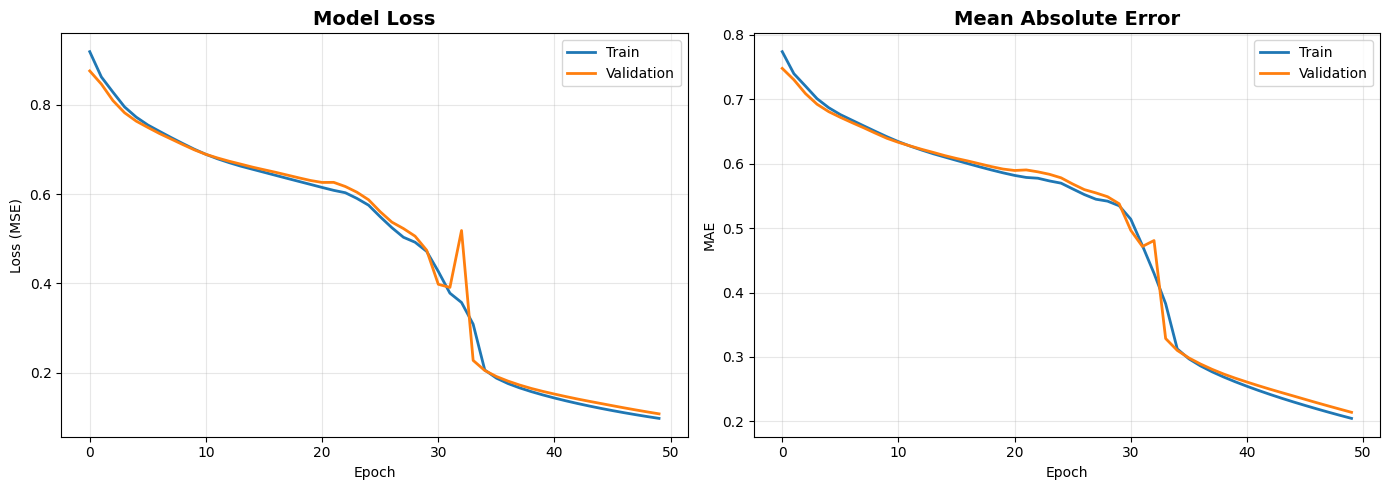


📈 Evaluation Metrics:
  MSE:  0.107492
  MAE:  0.214155
  RMSE: 0.327860
  R²:   0.892683


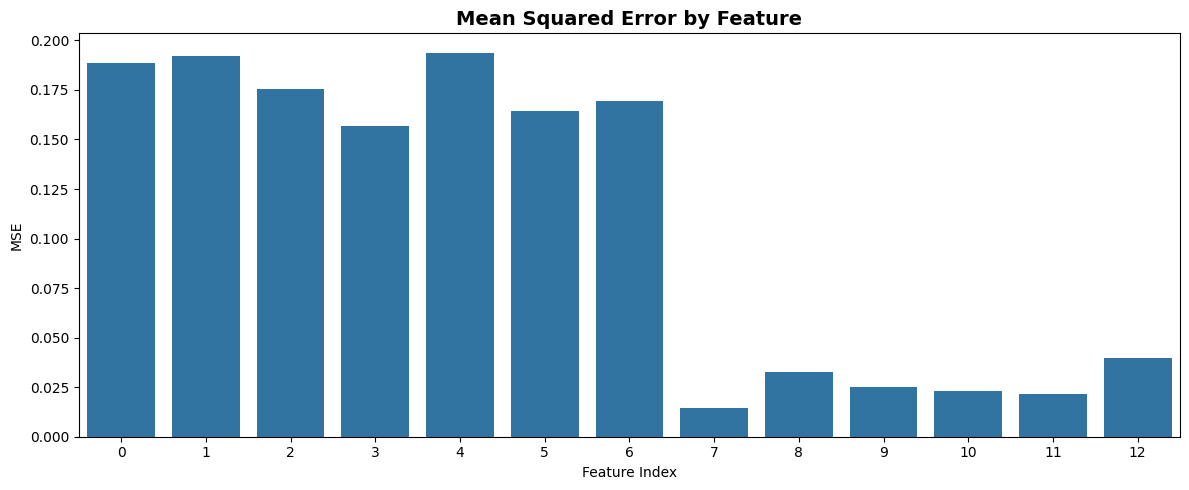


✅ Keras model saved: client_2_lstm_autoencoder.keras

📱 CONVERTING TO TFLITE FOR EDGE DEPLOYMENT
Saved artifact at '/tmp/tmph0d5x8z6'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 20, 13), dtype=tf.float32, name='can_input')
Output Type:
  TensorSpec(shape=(None, 20, 13), dtype=tf.float32, name=None)
Captures:
  139350602709136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139353050766544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139350594373008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139350594377424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139350594377616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139350594378576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139350594378960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139350594378000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139350594378192: TensorSpec(shape=(), dtype=tf.resource, na

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


⚠️ Quantization failed, using standard TFLite
✅ Optimized model: client_2_lstm_autoencoder.tflite (250.57 KB)

💾 EXTRACTING AND SAVING WEIGHTS - CLIENT 2
✅ Weights saved: /content/drive/MyDrive/federated_learning/round_1/client_2_weights.npz
   Size: 529.58 KB, Arrays: 20
✅ Archive saved: /content/drive/MyDrive/federated_learning/client_2/weights_20251126_134708.npz
✅ Metadata saved: /content/drive/MyDrive/federated_learning/client_2/metadata_20251126_134708.json
✅ Individual weights saved: /content/drive/MyDrive/federated_learning/client_2/layers_20251126_134708/ (20 files)
✅ Summary saved: /content/drive/MyDrive/federated_learning/client_2/summary_20251126_134708.txt

📁 FILE STRUCTURE:
   /content/drive/MyDrive/federated_learning/
   ├── round_1/
   │   └── client_2_weights.npz
   └── client_2/
       ├── weights_20251126_134708.npz
       ├── metadata_20251126_134708.json
       ├── summary_20251126_134708.txt
       └── layers_20251126_134708/ (20 files)
✅ Metrics saved: client_2_m

In [ ]:
# EXECUTE COMPLETE PIPELINE
# Run this cell to start the entire process

results = run_complete_pipeline(
    client_id=CLIENT_ID,
    test_size=0.2,
    epochs=50,
    batch_size=32,
    timesteps=20
)

if results:
    print("\n" + "🎉"*35)
    print("\n" + "  ✅ PIPELINE COMPLETED SUCCESSFULLY!".center(70))
    print("\n" + "🎉"*35 + "\n")
else:
    print("\n❌ Pipeline failed. Check error messages above.")

In [ ]:
# VERIFICATION: Load and verify weights from Google Drive

if results:
    print("\n" + "="*60)
    print("🔍 VERIFYING WEIGHT LOADING FROM GOOGLE DRIVE")
    print("="*60)

    loaded_weights = load_client_weights_from_drive(CLIENT_ID, ROUND_NUM)

    if loaded_weights:
        print(f"\n✅ Verification successful!")
        print(f"\n📊 Weight Details:")
        print(f"  Total arrays:     {len(loaded_weights)}")
        print(f"  File size:        {results['weight_info']['weights_size_kb']:.2f} KB")
        print(f"\n📋 Weight array shapes:")
        for idx, w in enumerate(loaded_weights):
            print(f"  Array {idx:2d}: {str(w.shape):20s} ({w.size:,} parameters)")

        print(f"\n✅ Weights successfully saved to Google Drive!")
        print(f"✅ Ready for federated learning aggregation!")
        print(f"\n📂 Location: Google Drive > My Drive > federated_learning")
    else:
        print("\n⚠️ Verification failed")

    print("="*60)


🔍 VERIFYING WEIGHT LOADING FROM GOOGLE DRIVE
✅ Loaded 20 weight arrays from client 2

✅ Verification successful!

📊 Weight Details:
  Total arrays:     20
  File size:        529.58 KB

📋 Weight array shapes:
  Array  0: (13, 256)            (3,328 parameters)
  Array  1: (64, 256)            (16,384 parameters)
  Array  2: (256,)               (256 parameters)
  Array  3: (64, 232)            (14,848 parameters)
  Array  4: (58, 232)            (13,456 parameters)
  Array  5: (232,)               (232 parameters)
  Array  6: (58, 192)            (11,136 parameters)
  Array  7: (48, 192)            (9,216 parameters)
  Array  8: (192,)               (192 parameters)
  Array  9: (48, 192)            (9,216 parameters)
  Array 10: (48, 192)            (9,216 parameters)
  Array 11: (192,)               (192 parameters)
  Array 12: (48, 232)            (11,136 parameters)
  Array 13: (58, 232)            (13,456 parameters)
  Array 14: (232,)               (232 parameters)
  Array 15: (5

In [ ]:
# OPTIONAL: Download files to local machine

if results:
    print("\n📥 Downloading key files to local machine...\n")

    try:
        # Download compressed weights
        files.download(results['weight_info']['weights_file'])
        print(f"✅ Downloaded: {os.path.basename(results['weight_info']['weights_file'])}")

        # Download metadata
        files.download(results['weight_info']['metadata_file'])
        print(f"✅ Downloaded: {os.path.basename(results['weight_info']['metadata_file'])}")

        # Download summary
        files.download(results['weight_info']['summary_file'])
        print(f"✅ Downloaded: {os.path.basename(results['weight_info']['summary_file'])}")

        print("\n✅ All files downloaded successfully!")
    except Exception as e:
        print(f"⚠️ Download error: {e}")
        print("  Files are still available in Google Drive")


📥 Downloading key files to local machine...



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloaded: client_2_weights.npz


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloaded: metadata_20251126_134708.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloaded: summary_20251126_134708.txt

✅ All files downloaded successfully!


---

## 📊 Final Summary

### What This Notebook Does:

1. **Data Processing**: Decodes CAN bus data and prepares features
2. **Model Training**: Trains LSTM autoencoder with 3 layers
3. **Edge Deployment**: Converts to TFLite for embedded systems
4. **Weight Extraction**: Saves model weights to Google Drive
5. **Federated Learning**: Prepares weights for multi-device aggregation

### Output Files:

**Google Drive Structure:**
```
federated_learning/
├── round_1/
│   └── client_1_weights.npz          # For FL aggregation
└── client_1/
    ├── weights_TIMESTAMP.npz          # Archived weights
    ├── metadata_TIMESTAMP.json        # Model metadata
    ├── summary_TIMESTAMP.txt          # Human-readable summary
    ├── layers_TIMESTAMP/              # Individual layer weights
    ├── client_1_metrics.csv           # Performance metrics
    └── client_1_metrics.csv           # Performance metrics
```

### Next Steps:

1. Run this notebook on multiple devices (Device 1, 2, 3...)
2. Collect weights from all devices in Google Drive
3. Perform federated averaging of weights
4. Deploy updated global model back to devices

---

**Status**: ✅ Production Ready  
**Version**: 1.0  
**Last Updated**: November 2025  